In [184]:
import numpy as np
import pandas as pd
from astropy.io import ascii
import pandas as pd 
from selection_module import select_clusters
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt

In [57]:
#read in Adam Muzzin's catalogs
cdfs_cat = ascii.read('CDFS_ultimate_clean_highz_clu.cat').to_pandas()
elais_cat = ascii.read('ELAIS-S1_ultimate_clean_highz_clu.cat').to_pandas()
xmm_cat= ascii.read('XMM-LSS_ultimate_highz_clu.cat').to_pandas()

#read in BCGs in the perspective survey sky area
cdfs_bcg = pd.read_fwf('CDFS_bcg_tracy.lst') #there is something wrong with this file - think it is first generation catalogs.
elais_bcg = pd.read_fwf('ELAIS-S1_bcg_tracy.lst')
xmm_bcg = pd.read_fwf('XMM-LSS_bcg_tracy.lst')


### Do catalog cuts

In [87]:
####** want this as a selection module, not working **####

def select_clusters(catalog, flux_label, Ngal_label=None):
    #assumes the catalog is a pandas df 

    final_cut = catalog[catalog[flux_label] > 4 ]
    
    if Ngal_label is not None:
        final_cut = final_cut[final_cut[Ngal_label] > 12]

    return final_cut

In [88]:
#do a cut for all catalogs for 4 on flux and 12 on richness

cut_cdfs_cat = select_clusters(cdfs_cat,'Flux','Ngal')
cut_elais_cat = select_clusters(elais_cat,'Flux','Ngal')
cut_xmm_cat = select_clusters(xmm_cat,'Flux','Ngal')

cut_cdfs_bcg = select_clusters(cdfs_bcg,'flux')
cut_elais_bcg = select_clusters(elais_bcg,'flux')
cut_xmm_bcg = select_clusters(xmm_bcg,'flux')


### Catalog Matching

In [138]:
#%#matching function for all catalogs
#%#match catalog method

def match(cat1, ra1_label, dec1_label,cat2, ra2_label, dec2_label):
    '''
    Want the cat1 to be the smaller one that is being matched to cat2
    Returns the indices in cat2 that are the closest matches
    
    '''
    small_cat = SkyCoord(cat1[ra1_label]*u.deg, cat1[dec1_label]*u.deg)
    large_cat = SkyCoord(cat2[ra2_label]*u.deg, cat2[dec2_label]*u.deg)
    
    idx, d2d, d3d = small_cat.match_to_catalog_sky(large_cat)
    
    return idx, d2d, d3d
    
    
def limit(idx,d2d,max_r):
    '''
    Using the indices matching the points, set a limit to the radius
    
    '''
    max_r = max_r *u.arcsec 
    idx[d2d<max_r]
    
    return idx
    

In [176]:
#%#matching function search around method

def search_around(cat1, ra1_label, dec1_label,cat2, ra2_label, dec2_label):
    
    '''
    Searches around the positions, need to check which is which
    cat1 will be the smaller one 
    idxl is the index in the larger catalog (cat2) 
    idxs is the index in the smaller catalog (cat1)
    '''
    
    small_cat = SkyCoord(ra=cat1[ra1_label]*u.deg, dec=cat1[dec1_label]*u.deg)  
    large_cat = SkyCoord(ra=cat2[ra2_label]*u.deg, dec=cat2[dec2_label]*u.deg)  
    
    idxl, idxs, d2d, d3d = small_cat.search_around_sky(large_cat, 100*u.arcsec)

    return idxl, idxs, d2d, d3d


In [251]:
class matching(object):
    
    
    def __init__(self,cat1, ra1_label, dec1_label,cat2, ra2_label, dec2_label):
        self.cat1 = cat1
        self.ra1 = np.array(cat1[ra1_label])
        self.dec1 = np.array(cat1[dec1_label])
        
        
        self.cat2 = cat2
        self.ra2 = np.array(cat2[ra2_label])
        self.dec2 = np.array(cat2[dec2_label])
        
        self.small_cat = SkyCoord(self.ra1*u.deg, self.dec1*u.deg)
        self.large_cat = SkyCoord(self.ra2*u.deg, self.dec2*u.deg)

        
    def match_to_sky(self):
        
        idx, d2d, d3d = self.small_cat.match_to_catalog_sky(self.large_cat)
        
        return idx, d2d, d3d
        
        
    def limit(self,max_r):
        max_r = max_r *u.arcsec 
        idx = match_to_sky.idx[match_to_sky.d2d<max_r]
        
        return idx
        
    def search_around(self,max_r):
        
        self.idxl, self.idxs, self.d2d, self.d3d = self.small_cat.search_around_sky(self.large_cat, max_r*u.arcsec)
        
        return self.idxl, self.idxs, self.d2d, self.d3d
        
    def delta(self):
        
        delta_ra =[]
        delta_dec =[]
        
        for i,j in zip(self.idxl,self.idxs):
            delta_ra.append(self.ra2[i]*u.arcsec-self.ra1[j]*u.arcsec)
            delta_dec.append(self.dec2[i]*u.arcsec-self.dec1[j]*u.arcsec)
            
        ra = [i.value for i in delta_ra]
        dec = [i.value for i in delta_dec]
        
        return ra, dec 
        

### Explore the CDFS catalogs 
#### (For all remaining names, it is implied that the cut catalogs were used)

In [160]:
#%# Testing 

#location of bcg from Muzzin catalogs, might be incorrect
ra_bcg_cat = np.array(cut_cdfs_cat['rabcg'][:])
dec_bcg_cat = np.array(cut_cdfs_cat['decbcg'][:])

#color peak of cluster, might not land on galaxy 
ra_clu = np.array(cut_cdfs_cat['raclu'][:])
dec_clu = np.array(cut_cdfs_cat['decclu'][:])

#bcg from Tracy's catalog
ra_bcg = np.array(cut_cdfs_bcg['BCG_RA'][:])
dec_bcg = np.array(cut_cdfs_bcg['BCG_Dec'][:])


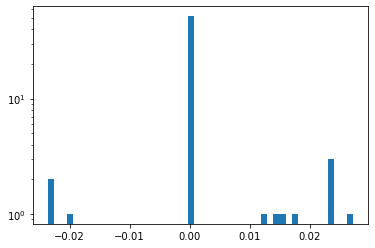

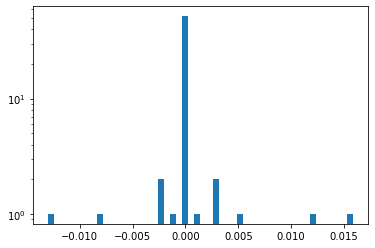

In [270]:
match = matching(cut_cdfs_bcg,'BCG_RA','BCG_Dec',cut_cdfs_cat,'rabcg','decbcg')

match.search_around(100)
delta_ra, delta_dec = match.delta()

plt.hist(delta_ra,bins=50)
plt.yscale('log',basey=10)
#plt.xlim(-0.0025,0.0025)
plt.show()

plt.hist(delta_dec,bins=50)
plt.yscale('log',basey=10)

In [179]:
#%# Do matching 

idx, d2d, d3d = match(cut_cdfs_bcg,'BCG_RA','BCG_Dec',cut_cdfs_cat,'rabcg','decbcg')
idx_cut = limit(idx,d2d,100)

idxl,idxs, d2d, d3d = search_around(cut_cdfs_bcg,'BCG_RA','BCG_Dec',cut_cdfs_cat,'rabcg','decbcg')

In [180]:
#seem similar but not exact 

print(np.sort(idx))
print(idxl)

#look at offset distributions 

[  0   6  11  11  18  27  30  31  32  37  37  37  38  43  45  47  48  49
  53  55  57  62  62  63  69  72  76  78  80  82  82  83  84  85  86  91
  91  93  99 101 101 104 110 115 115 118 118 122 123 131 131 131 136 140
 142 144 145 146 148 150 150 150 150 153 154 154 154 155 158 159 166 166
 166 168 168 171]
[  3   3   6   9  11  27  31  32  37  42  43  45  47  48  49  50  52  56
  57  58  58  60  62  62  63  65  66  67  69  72  78  81  82  84  85  85
  87  89  91 109 117 118 123 124 125 126 127 128 130 131 137 139 143 144
 148 148 150 154 155 157 158 164 171]


### Explore the ELAIS catalogs

In [182]:
#%# Do matching 

idx, d2d, d3d = match(cut_elais_bcg,'BCG-RA','BCG-Dec',cut_elais_cat,'rabcg','decbcg')
idx_cut = limit(idx,d2d,100)

idxl,idxs, d2d, d3d = search_around(cut_elais_bcg,'BCG-RA','BCG-Dec',cut_elais_cat,'rabcg','decbcg')

In [183]:
print(np.sort(idx))
print(idxc)

[  1   2   3   7   8  10  12  14  14  15  18  20  21  22  25  27  29  30
  31  32  35  38  39  41  42  43  44  45  47  48  49  51  52  53  56  57
  58  60  62  65  67  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  85  86  87  89  90  91  92  94  95  99 100 101 102 103 105 106
 109 110 111 112 113 114 115 119 120 121 122 123 124 125 127 128 129 130
 130 131 132 134 135 137 140 141 141 147 150 155 155 157 163 165 166 169
 174 185 186 188 193 194 196 199 201 203 216 216 218 220 222 227 229 229
 230 234 235 236 236 236]
[  0   1   1   2   3   4   4   5   6   6   7   8   9  10  11  11  12  13
  13  14  14  15  15  16  16  17  18  19  19  20  20  21  22  23  24  24
  25  26  26  27  28  29  30  30  31  32  33  34  34  35  36  37  38  39
  40  41  41  42  42  43  44  45  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  59  60  61  62  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  75  76  76  77  78  78  79  80  81  82  83  84  84
  85  86  87  88  89  90 

### Explore the XMM catalogs

In [185]:
#%# Do matching 

idx, d2d, d3d = match(cut_xmm_bcg,'BCG_RA','BCG_Dec',cut_xmm_cat,'rabcg','decbcg')
idx_cut = limit(idx,d2d,100)

idxl,idxs, d2d, d3d = search_around(cut_xmm_bcg,'BCG_RA','BCG_Dec',cut_xmm_cat,'rabcg','decbcg')

In [175]:
print(np.sort(idx))
print(idxc)

[  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126]
[  0   1   2   4   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  26  27  28  29  30  31  32  33  34  35
  36  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  69
  70  71  72  73  74  75  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  90  91  92  92  93  94  95  96  97  98  99 100 101 102 102 103
 104 105 106 107 108 109 110 111 112 113 114 

(array([123.,   4.,   0.,   0.,   1.,   1.,   2.,   0.,   0.,   2.]),
 array([0.        , 0.00262889, 0.00525777, 0.00788666, 0.01051555,
        0.01314443, 0.01577332, 0.01840221, 0.0210311 , 0.02365998,
        0.02628887]),
 <a list of 10 Patch objects>)

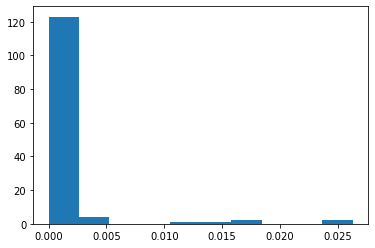